In [ ]:

!pip install transformers pandas scikit-learn


from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report


model_name = "MB55/qlora_new"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)

df = pd.read_excel("/content/outofdomain_eval_data.xlsx")  # make sure file is uploaded!

predictions = []
references = []

model.eval()


label_mapping = {0: "NON_ADVANCE", 1: "ADVANCE"}

for idx, row in tqdm(df.iterrows(), total=len(df)):
    if pd.notna(row['end_label']):
        inputs = tokenizer(
            row['input_text'],
            return_tensors="pt",
            truncation=True,
            padding=True,
            max_length=512
        ).to(model.device)

        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.logits
        pred_id = torch.argmax(logits, dim=-1).item()
        pred_label = label_mapping[pred_id]

        predictions.append(pred_label.upper())
        references.append(row['end_label'].upper())


accuracy = accuracy_score(references, predictions)
print(f"\nOut-of-domain Test Accuracy: {accuracy:.4f}\n")
print(classification_report(references, predictions, digits=4))


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at LSX-UniWue/LLaMmlein_7B_chat and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 780/780 [00:37<00:00, 20.53it/s]


Out-of-domain Test Accuracy: 0.6538

              precision    recall  f1-score   support

     ADVANCE     0.6083    0.8641    0.7140       390
 NON_ADVANCE     0.7655    0.4436    0.5617       390

    accuracy                         0.6538       780
   macro avg     0.6869    0.6538    0.6378       780
weighted avg     0.6869    0.6538    0.6378       780



In [ ]:
results_df = pd.DataFrame({
    "input_text": df['input_text'],
    "true_label": references,
    "predicted_label": predictions
})

results_df.to_csv("out_of_domain_predictions.csv", index=False)


In [ ]:
from sklearn.metrics import classification_report


report = classification_report(references, predictions, digits=4)
accuracy = accuracy_score(references, predictions)


with open("out_of_domain_evaluation.txt", "w") as f:
    f.write(f"Test Set Accuracy: {accuracy:.4f}\n\n")
    f.write(report)


In [ ]:


!pip install matplotlib seaborn scikit-learn


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


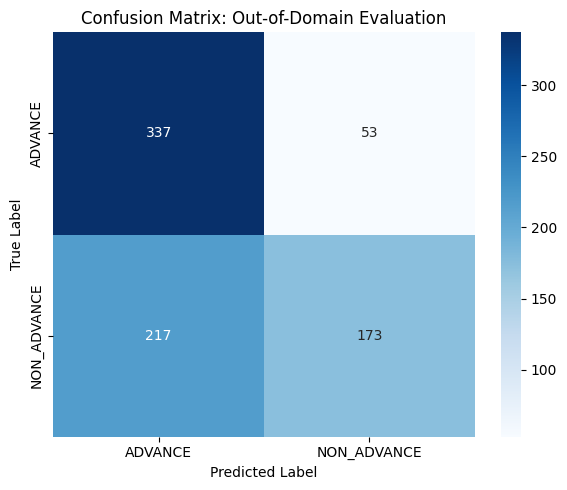

In [ ]:
cm = confusion_matrix(references, predictions, labels=["ADVANCE", "NON_ADVANCE"])


class_names = ["ADVANCE", "NON_ADVANCE"]


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Out-of-Domain Evaluation')
plt.tight_layout()


plt.savefig("confusion_matrix_outofdomain.png")
plt.show()


In [ ]:
from google.colab import files
files.download("confusion_matrix_outofdomain.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>